In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy

# Custom modules
from model import *

In [3]:
# Load dataset
MNIST_TEST = datasets.MNIST(root='./../datasets', train=False, download=True, transform=transforms.ToTensor())
dataset0to4 = list(filter(lambda i: i[1] in [0, 1, 2, 3, 4], MNIST_TEST))
dataset5to9 = list(filter(lambda i: i[1] in [5, 6, 7, 8, 9], MNIST_TEST))
dataloader0to4 = DataLoader(dataset0to4, shuffle=True, batch_size=256)
dataloader5to9 = DataLoader(dataset5to9, shuffle=True, batch_size=256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Base Model

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/2 loss: 0.81


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/2 loss: 0.15


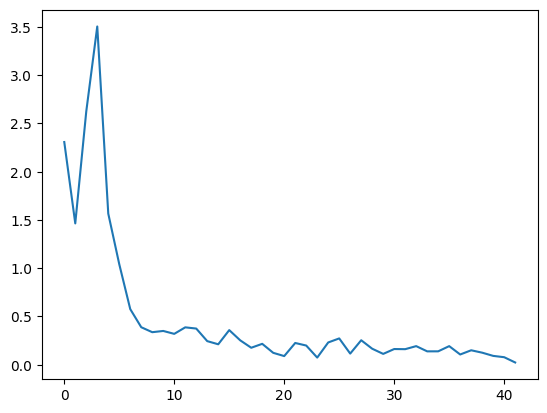

In [4]:
torch.manual_seed(42)
base_model = TheModel()
base_model.to(device)
dataloader = dataloader0to4

num_epochs = 2

optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []
for epoch in tqdm(range(num_epochs), leave=True):
    train_loss = 0.0
    for batch in tqdm(dataloader, leave=False): 
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = base_model(x)
        loss = criterion(y_hat, y)

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(dataloader)
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

plt.plot(losses)
plt.show()

In [5]:
def eval_model(model, dataloader):
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=-1)
            total += labels.shape[0]
            correct += (predictions == labels).sum().item()
        accuracy = correct / total

    print(f"{accuracy*100:.2f}%")

In [6]:
eval_model(base_model, dataloader0to4)
eval_model(base_model, dataloader5to9)

96.59%
0.00%


# Full Finetuning

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/2 loss: 1.98


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/2 loss: 0.27


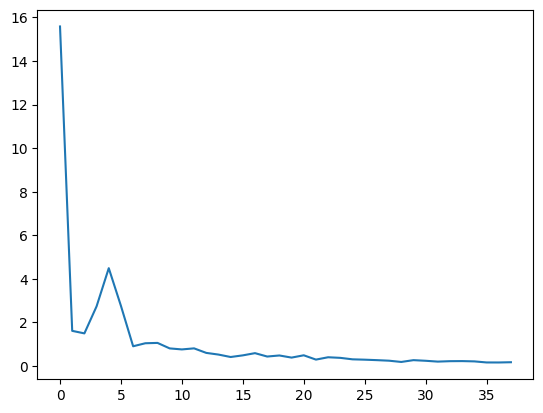

In [7]:
torch.manual_seed(42)
full_finetune_model = copy.deepcopy(base_model)
full_finetune_model.train()
dataloader = dataloader5to9

num_epochs = 2

optimizer = torch.optim.Adam(full_finetune_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []
for epoch in tqdm(range(num_epochs), leave=True):
    train_loss = 0.0
    for batch in tqdm(dataloader, leave=False): 
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = full_finetune_model(x)
        loss = criterion(y_hat, y)

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(dataloader)
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

plt.plot(losses)
plt.show()

In [8]:
eval_model(full_finetune_model, dataloader0to4)
eval_model(full_finetune_model, dataloader5to9)

0.00%
94.03%


# Head-only Finetuning

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/2 loss: 1.56


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/2 loss: 0.27


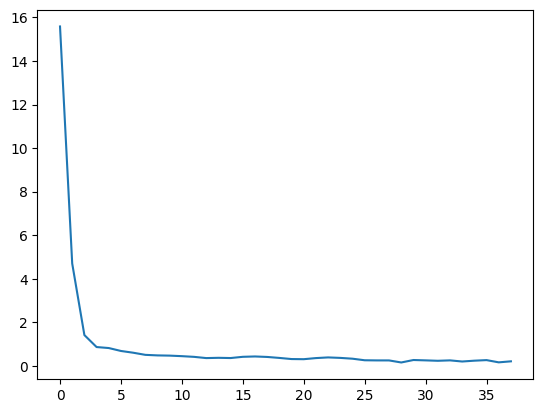

In [9]:
torch.manual_seed(42)
head_finetune_model = copy.deepcopy(base_model)
head_finetune_model.train()
dataloader = dataloader5to9

num_epochs = 2

optimizer = torch.optim.Adam(head_finetune_model.mlp_head.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []
for epoch in tqdm(range(num_epochs), leave=True):
    train_loss = 0.0
    for batch in tqdm(dataloader, leave=False): 
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = head_finetune_model(x)
        loss = criterion(y_hat, y)

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(dataloader)
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

plt.plot(losses)
plt.show()

In [10]:
eval_model(head_finetune_model, dataloader0to4)
eval_model(head_finetune_model, dataloader5to9)

0.00%
92.31%


# Memory

Add learnable memory, fine tune head + memory.

Parameter containing:
tensor([[ 0.0385,  0.0297,  0.0180,  ..., -0.0039, -0.0211,  0.0256],
        [-0.0034,  0.0105,  0.0011,  ...,  0.0207, -0.0137,  0.0127],
        [-0.0195,  0.0192,  0.0324,  ...,  0.0088, -0.0030, -0.0464],
        ...,
        [ 0.0174, -0.0211, -0.0266,  ...,  0.0250,  0.0196,  0.0045],
        [ 0.0099, -0.0103,  0.0060,  ...,  0.0105,  0.0070,  0.0050],
        [ 0.0238,  0.0282,  0.0160,  ..., -0.0121,  0.0129, -0.0050]],
       device='cuda:0', requires_grad=True)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/2 loss: 1.58


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/2 loss: 0.27


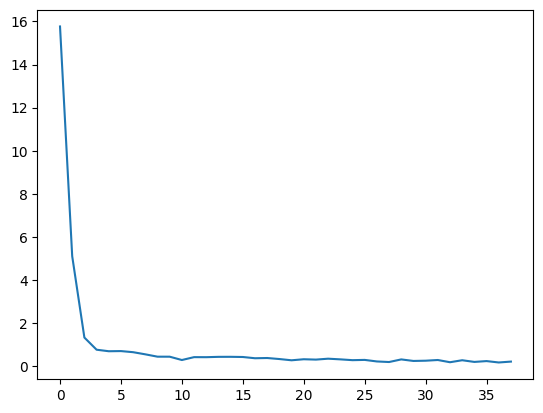

Parameter containing:
tensor([[ 0.0480,  0.0166,  0.0111,  ..., -0.0136, -0.0212,  0.0331],
        [ 0.0062, -0.0025, -0.0061,  ...,  0.0107, -0.0147,  0.0206],
        [-0.0098,  0.0062,  0.0251,  ..., -0.0012, -0.0036, -0.0385],
        ...,
        [ 0.0270, -0.0341, -0.0338,  ...,  0.0150,  0.0192,  0.0124],
        [ 0.0193, -0.0227, -0.0011,  ...,  0.0006,  0.0069,  0.0131],
        [ 0.0334,  0.0155,  0.0088,  ..., -0.0221,  0.0126,  0.0031]],
       device='cuda:0', requires_grad=True)


In [11]:
torch.manual_seed(42)
memory_finetune_model = copy.deepcopy(base_model)
memory_finetune_model.train()
memory_finetune_model.add_memory(16)
dataloader = dataloader5to9

print(memory_finetune_model.transformer.attention.memory)

num_epochs = 2

parameters = list(memory_finetune_model.mlp_head.parameters()) + memory_finetune_model.memory_parameters()
#parameters = memory_finetune_model.memory_parameters()
optimizer = torch.optim.Adam(parameters, lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []
for epoch in tqdm(range(num_epochs), leave=True):
    train_loss = 0.0
    for batch in tqdm(dataloader, leave=False): 
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = memory_finetune_model(x)
        loss = criterion(y_hat, y)

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(dataloader)
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

plt.plot(losses)
plt.show()
print(memory_finetune_model.transformer.attention.memory)

In [12]:
eval_model(memory_finetune_model, dataloader0to4)
eval_model(memory_finetune_model, dataloader5to9)

0.00%
93.33%


# Train from scratch with memory

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/2 loss: 0.50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/2 loss: 0.13


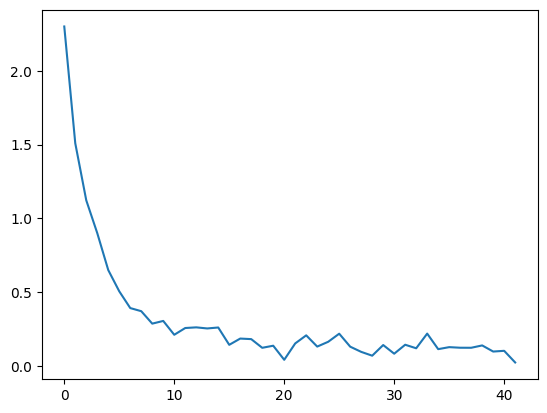

In [13]:
torch.manual_seed(42)
memory_model = TheModel()
memory_model.add_memory(16)
memory_model.to(device)
dataloader = dataloader0to4

num_epochs = 2

parameters = list(memory_model.mlp_head.parameters()) + memory_model.memory_parameters()
#parameters = memory_model.memory_parameters()
optimizer = torch.optim.Adam(parameters, lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []
for epoch in tqdm(range(num_epochs), leave=True):
    train_loss = 0.0
    for batch in tqdm(dataloader, leave=False): 
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = memory_model(x)
        loss = criterion(y_hat, y)

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(dataloader)
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

plt.plot(losses)
plt.show()

In [14]:
eval_model(memory_model, dataloader0to4)
eval_model(memory_model, dataloader5to9)

96.71%
0.00%
